### Save to Model Catalog

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb
import imblearn

from sklearn.metrics import classification_report
from sklearn.metrics import get_scorer, make_scorer, f1_score, roc_auc_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler, OrdinalEncoder, LabelEncoder

# to rebalance
from imblearn.over_sampling import RandomOverSampler

from utils import (cat_cols_selector,
                  num_cols_selector,
                  plot_cm,
                  evaluate_metrics)

# to save to Model Catalog
from ads import set_auth
from ads.catalog.model import ModelCatalog
from ads.model.model_metadata import UseCaseType, MetadataCustomCategory
from ads.model.framework.lightgbm_model import LightGBMModel

%matplotlib inline

In [2]:
NAMESPACE = "frqap2zhtzbe"
BUCKET = "WORKSHOP"
NOME_FILE = "customer_churn_data.csv"

URL = f"oci://{BUCKET}@{NAMESPACE}/{NOME_FILE}"

orig_df = pd.read_csv(URL)

In [3]:
# get rid of some columns
cols_to_drop = ['customerID', 'TotalCharges']

df = orig_df.drop(columns=cols_to_drop)

TARGET = "Churn"
features = list(set(df.columns) - set([TARGET]))

In [4]:
# identify categorical and continuous
cat_cols = cat_cols_selector(df, TARGET)
num_cols = num_cols_selector(df, TARGET)

In [5]:
# code categorical as integer for LightGBM
enc = OrdinalEncoder()
enc.fit(df[cat_cols])

df[cat_cols] = enc.transform(df[cat_cols])

for col in cat_cols:
    df[col] = df[col].astype("category")

In [6]:
# train, test split (lo faccio direttamente sui dataframe)
SEED = 42

TEST_FRAC = 0.2

df_train, df_test = train_test_split(df, shuffle=True, test_size=TEST_FRAC, 
                                     random_state = SEED)

X_train, y_train = df_train.drop([TARGET], axis=1), df_train[TARGET]
X_test, y_test = df_test.drop([TARGET], axis=1), df_test[TARGET]

print("# of samples in train set", df_train.shape[0])
print("# of samples in test set", df_test.shape[0])

print()
print(f'Numerical columns: {num_cols} ({len(num_cols)})')
print()
print(f'Categorical columns: {cat_cols} ({len(cat_cols)})')

# of samples in train set 5634
# of samples in test set 1409

Numerical columns: ['tenure', 'MonthlyCharges'] (2)

Categorical columns: ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod'] (16)


In [7]:
SEED = 42

ros = RandomOverSampler(random_state=SEED)

In [8]:
# bilanciamo solo il training set, il test set NON è toccato
X_train_reb, y_train_reb = ros.fit_resample(X_train, y_train)

In [9]:
params = {'learning_rate': 0.099,
          'max_depth': 15,
          'n_estimators': 140,
          'num_leaves': 24}

model = lgb.LGBMClassifier(**params)

In [10]:
model.fit(X_train_reb, y_train_reb)

LGBMClassifier(learning_rate=0.099, max_depth=15, n_estimators=140,
               num_leaves=24)

In [11]:
metrics = evaluate_metrics(model, X_test, y_test)

Validation set result:
{'accuracy': 0.7757, 'roc_auc': 0.8481}


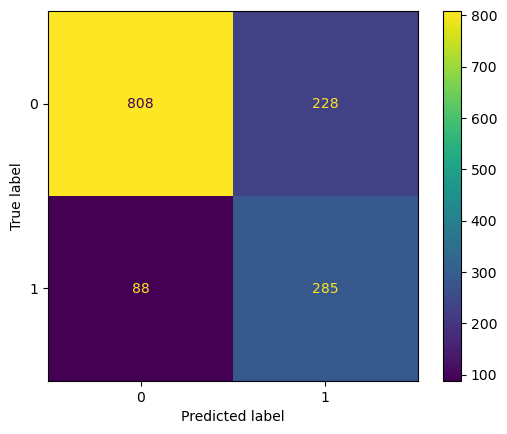

In [12]:
plot_cm(model, X_test, y_test)

### Il modello è abbastanza valido nell'identificare i positivi (recall elevata)

### Salviamo in Model Catalog

In [13]:
set_auth(auth='resource_principal')

# incapsuliamo nella opportuna classe del framework
lightgbm_model = LightGBMModel(estimator=model, artifact_dir="model_dir")

In [14]:
CONDA_ENV = "oci://conda_envs@frqap2zhtzbe/conda_environments/cpu/mygeneralml_p37_cpu_/1.0/mygeneralml_p37_cpu_v1_0"

lightgbm_model.prepare(
    inference_conda_env=CONDA_ENV,
    training_conda_env=CONDA_ENV,
    use_case_type=UseCaseType.BINARY_CLASSIFICATION,
    as_onnx=False,
    X_sample=X_test,
    y_sample=y_test,
    force_overwrite=True,
)

algorithm: LGBMClassifier
artifact_dir:
  /home/datascience/workshop-marzo-2023/model_dir:
  - - input_schema.json
    - .model-ignore
    - test_json_output.json
    - model.joblib
    - runtime.yaml
    - score.py
    - output_schema.json
    - .ipynb_checkpoints
    - .ipynb_checkpoints/score-checkpoint.py
framework: lightgbm
model_deployment_id: null
model_id: null

In [15]:
lightgbm_model.summary_status()

Actions Needed
Step      Status        Details                                                           
initiate  Done          Initiated the model                                               
prepare() Done          Generated runtime.yaml                                            
                        Generated score.py                                                
                        Serialized model                                                  
                        Populated metadata(Custom, Taxonomy and Provenance)               
verify()  Available     Local tested .predict from score.py                               
save()    Available     Conducted Introspect Test                                         
                        Uploaded artifact to model catalog                                
deploy()  Not Available Deployed the model                                                
predict() Not Available Called deployment predict endpoint

In [16]:
lightgbm_model.metadata_custom

data:
- category: Training Environment
  description: The slug name of the training conda environment.
  key: SlugName
  value: mygeneralml_p37_cpu_v1_0
- category: Other
  description: ''
  key: ClientLibrary
  value: ADS
- category: Training Environment
  description: The URI of the training conda environment.
  key: CondaEnvironmentPath
  value: oci://conda_envs@frqap2zhtzbe/conda_environments/cpu/mygeneralml_p37_cpu_/1.0/mygeneralml_p37_cpu_v1_0
- category: Other
  description: The model file name.
  key: ModelFileName
  value: model.joblib
- category: Training Environment
  description: The list of files located in artifacts folder.
  key: ModelArtifacts
  value: input_schema.json, .model-ignore, test_json_output.json, model.joblib, runtime.yaml,
    score.py, output_schema.json, .ipynb_checkpoints, .ipynb_checkpoints/score-checkpoint.py
- category: Training Profile
  description: The model serialization format.
  key: ModelSerializationFormat
  value: joblib
- category: Training 

In [17]:
lightgbm_model.metadata_custom.add(key='metrics on test set', value=str(metrics), category=MetadataCustomCategory.PERFORMANCE, 
                                  description='Metrics evaluated on reference dataset', replace=True)

In [ ]:
MODEL_NAME = "customer churn marzo 2023-1"
model_id = lightgbm_model.save(display_name=MODEL_NAME)

print(f"Model id in Model Catalog is {model_id}")

In [ ]:
lightgbm_model.summary_status()